In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/surface-crack-detection/Negative/08450.jpg
/kaggle/input/surface-crack-detection/Negative/19812.jpg
/kaggle/input/surface-crack-detection/Negative/16916.jpg
/kaggle/input/surface-crack-detection/Negative/05938.jpg
/kaggle/input/surface-crack-detection/Negative/06122.jpg
/kaggle/input/surface-crack-detection/Negative/08536.jpg
/kaggle/input/surface-crack-detection/Negative/12666.jpg
/kaggle/input/surface-crack-detection/Negative/04168.jpg
/kaggle/input/surface-crack-detection/Negative/13288.jpg
/kaggle/input/surface-crack-detection/Negative/02371.jpg
/kaggle/input/surface-crack-detection/Negative/04377.jpg
/kaggle/input/surface-crack-detection/Negative/09924.jpg
/kaggle/input/surface-crack-detection/Negative/00767.jpg
/kaggle/input/surface-crack-detection/Negative/07457.jpg
/kaggle/input/surface-crack-detection/Negative/10304.jpg
/kaggle/input/surface-crack-detection/Negative/02360.jpg
/kaggle/input/surface-crack-detection/Negative/14143.jpg
/kaggle/input/surface-crack-det

In [2]:
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
positive_dir = '/kaggle/input/surface-crack-detection/Positive/'
negative_dir = '/kaggle/input/surface-crack-detection/Negative/'

positive_images = os.listdir(positive_dir)
negative_images = os.listdir(negative_dir)

len(positive_images), len(negative_images)

(20000, 20000)

In [4]:
# Making train val split
train_positive_images = positive_images[:int(.8*(len(positive_images)))]
val_positive_images = positive_images[int(.8*(len(positive_images))):]

train_negative_images = negative_images[:int(.8*(len(negative_images)))]
val_negative_images = negative_images[int(.8*(len(negative_images))):]

train_dir = './train_data/'
val_dir = './val_data/'

os.makedirs(train_dir + 'Positive/')
os.makedirs(train_dir + 'Negative/')


os.makedirs(val_dir + 'Positive/')
os.makedirs(val_dir + 'Negative/')

In [5]:
for image in train_positive_images:
    src = positive_dir + image
    dst = train_dir + 'Positive/'
    shutil.copy(src, dst)
    
for image in train_negative_images:
    src = negative_dir + image
    dst = train_dir + 'Negative/'
    shutil.copy(src, dst)
    
for image in val_positive_images:
    src = positive_dir + image
    dst = val_dir + 'Positive/'
    shutil.copy(src, dst)
    
for image in val_negative_images:
    src = negative_dir + image
    dst = val_dir + 'Negative/'
    shutil.copy(src, dst)

In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class + '/'
    random_image = random.choice(os.listdir(target_folder))
    
    img = mpimg.imread(target_folder + random_image)
    print(img.shape)
    plt.title(target_class)
    plt.imshow(img)
    plt.axis('off')

(227, 227, 3)


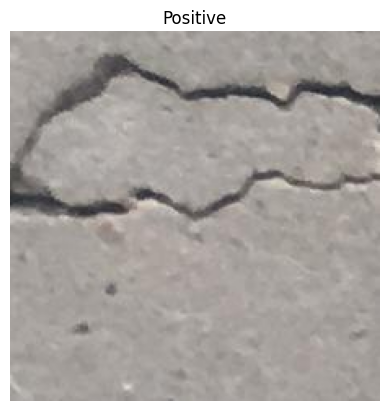

In [7]:
view_random_image(train_dir, 'Positive')

In [8]:
train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

train_dataset = train_data_gen.flow_from_directory(train_dir,
                                                  target_size = (227,227),
                                                  class_mode = 'binary')

val_dataset = val_data_gen.flow_from_directory(val_dir,
                                              target_size = (227,227),
                                              class_mode = 'binary')

Found 32000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [9]:
input_shape = (227,227,3)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = input_shape),
    
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, 3, activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy',
             metrics = ['accuracy'],
             optimizer = 'adam')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 10)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 10)        0

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 15)

history= model.fit(train_dataset,
                  epochs = 100,
                  validation_data = val_dataset,
                  callbacks = [early_stopping])

Epoch 1/100
1000/1000 [==============================] - 63s 52ms/step - loss: 0.2558 - accuracy: 0.8985 - val_loss: 0.1266 - val_accuracy: 0.9578
Epoch 2/100
1000/1000 [==============================] - 51s 51ms/step - loss: 0.1210 - accuracy: 0.9661 - val_loss: 0.1174 - val_accuracy: 0.9684
Epoch 3/100
1000/1000 [==============================] - 54s 54ms/step - loss: 0.1055 - accuracy: 0.9703 - val_loss: 0.1015 - val_accuracy: 0.9639
Epoch 4/100
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1003 - accuracy: 0.9700 - val_loss: 0.0777 - val_accuracy: 0.9796
Epoch 5/100
1000/1000 [==============================] - 51s 51ms/step - loss: 0.0800 - accuracy: 0.9758 - val_loss: 0.0688 - val_accuracy: 0.9776
Epoch 6/100
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0838 - accuracy: 0.9762 - val_loss: 0.0636 - val_accuracy: 0.9799
Epoch 7/100
1000/1000 [==============================] - 52s 52ms/step - loss: 0.0769 - accuracy: 0.9781 - val_loss: 0